# Converting ATN netCDF file to Dawrin Core

Created: 2022-03-23

This notebook walks through downloading an example netCDF file from the ATN GitHub repository and translating it to a Darwin Core Archive compliant package for easy loading and publishing via the Integrated Publishing Toolkit (IPT). The example file follows a specific specification for ATN satellite trajectory observations as documented [here](https://github.com/ioos/ioos-atn-data/blob/main/templates/atn_trajectory_template.cdl). More information about the ATN netCDF specification can be found in the repository https://github.com/ioos/ioos-atn-data.

Since most of the examples in the IOOS Code Lab are in the python programming language, we wanted to show an example of working with a netCDF file in the R programming language to be inclusive of those users. 

For more information on the tidync package, see this R blog: [https://ropensci.org/blog/2019/11/05/tidync/](https://ropensci.org/blog/2019/11/05/tidync/)

Data used in this notebook are available from NCEI at the following link https://www.ncei.noaa.gov/archive/accession/0282699.

In [1]:
#Load libraries

library(tidync)
library(obistools)
library(ncdf4)
library(tidyverse) #includes stringr
library(lubridate)
library(maps)
library(mapdata)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.2     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
-- Conflicts -----------------------------------------------------------------------------------------------------------------------------------------

## Download the netCDF file from the NCEI Archive

See https://www.ncei.noaa.gov/archive/accession/0282699

In [2]:
url = 'https://www.nodc.noaa.gov/archive/arc0217/0282699/1.1/data/0-data/atn_45866_great-white-shark_trajectory_20090923-20091123.nc'

#fname = str_split_i(url, "/", i=-1)
fname = basename(url)

download.file(url, fname, mode = "wb")

## Open the netCDF file
Once the file is opened, we print out the details of what the netCDF file contains.

In [3]:
atn <- nc_open(fname)
atn

File atn_45866_great-white-shark_trajectory_20090923-20091123.nc (NC_FORMAT_NETCDF4):

     36 variables (excluding dimension variables):
        string deploy_id[]   (Contiguous storage)  
            long_name: id for this deployment. This is typically the tag ptt
            comment: Friendly name given to the tag by the user. If no specific friendly name is given, this is the PTT id.
            coordinates: time z lon lat
            instrument: instrument_location
            platform: animal
            coverage_content_type: referenceInformation
            _FillValue: -9999
        double time[obs]   (Contiguous storage)  
            units: seconds since 1990-01-01 00:00:00Z
            standard_name: time
            axis: T
            _CoordinateAxisType: Time
            calendar: standard
            long_name: Time of the measurement, in seconds since 1990-01-01
            actual_min: 2009-09-23T00:00:00Z
            actual_max: 2009-11-23T05:12:00Z
            ancilla

## Collect all the metadata from the netCDF file.

This gathers not only the global attributes, but the variable level attributes as well. As you can see in the **variable** column the term `NC_GLOBAL` refers to global attributes.

In [4]:
metadata <- ncmeta::nc_atts(fname)

## Example extracting `long_name` attributes

To give you an idea of what observations are in this file, we can print out the human readable `long_name` attribute from all the variables.

In [5]:
metadata %>% dplyr::filter(name == "long_name")

id,name,variable,value
<int>,<chr>,<chr>,<named list>
0,long_name,deploy_id,id for this deployment. This is typically the tag ptt
5,long_name,time,"Time of the measurement, in seconds since 1990-01-01"
2,long_name,z,depth of measurement
2,long_name,lat,Latitude portion of location in decimal degrees North
2,long_name,lon,Longitude portion of location in decimal degrees East
2,long_name,ptt,Platform Transmitter Terminal (PTT) id used for Argos transmissions
2,long_name,instrument,Instrument family
2,long_name,type,"Type of location information - Argos, GPS satellite or user provided location"
3,long_name,location_class,Location Quality Code from ARGOS satellite system


## Store the data as a tibble in a variable
Collect the data dimensioned by `time` from the netCDF file as a tibble. Then, print the first few rows.

In [6]:
atn <- tidync(fname)

atn_tbl <- atn %>% hyper_tibble(force=TRUE)

head(atn_tbl, n=4)

time,z,lat,lon,ptt,instrument,type,location_class,error_radius,semi_major_axis,...,offset_orientation,gpe_msd,gpe_u,count,qartod_time_flag,qartod_speed_flag,qartod_location_flag,qartod_rollup_flag,comment,obs
<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,...,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
622512000,0,34.030,-118.560,45866,SPOT,User,nan,NA,NA,...,NA,NaN,NaN,NA,1,2,1,1,,1
622708920,0,23.590,-166.180,45866,SPOT,Argos,A,NA,NA,...,NA,NaN,NaN,NA,1,4,1,4,,2
622724940,0,34.024,-118.556,45866,SPOT,Argos,1,NA,NA,...,NA,NaN,NaN,NA,1,4,1,4,,3
622725060,0,34.035,-118.549,45866,SPOT,Argos,0,NA,NA,...,NA,NaN,NaN,NA,1,4,1,4,,4


## Dealing with time

Notice the data in the **time** column aren't formatted as times. We need to read the metadata associated with the time variable to understand what the units are. Below, we print a tibble of all the attributes from the **time** variable.

Notice the _units_ attribute and it's value of `seconds since 1990-01-01 00:00:00Z`. We need to use that information to convert the time variable to something useful that `ggplot` can handle.

In [7]:
time_attrs <- metadata %>% dplyr::filter(variable == "time")
time_attrs

id,name,variable,value
<int>,<chr>,<chr>,<named list>
0,units,time,seconds since 1990-01-01 00:00:00Z
1,standard_name,time,time
2,axis,time,T
3,_CoordinateAxisType,time,Time
4,calendar,time,standard
5,long_name,time,"Time of the measurement, in seconds since 1990-01-01"
6,actual_min,time,2009-09-23T00:00:00Z
7,actual_max,time,2009-11-23T05:12:00Z
8,ancillary_variables,time,qartod_time_flag qartod_rollup_flag qartod_speed_flag


So, we grab the value from the `units` attribute, split the string to collect the date information, and apply that to a time conversion function `as.POSIXct`.

In [8]:
#library(stringr) - loaded with tidyverse
# grab origin date from time variable units attribute
tunit <- time_attrs %>% dplyr::filter(name == "units")
lunit <- str_split(tunit$value,' ')[[1]]
atn_tbl$time <- as.POSIXct(atn_tbl$time, origin=lunit[3], tz="GMT")

head(atn_tbl, n=2)

time,z,lat,lon,ptt,instrument,type,location_class,error_radius,semi_major_axis,...,offset_orientation,gpe_msd,gpe_u,count,qartod_time_flag,qartod_speed_flag,qartod_location_flag,qartod_rollup_flag,comment,obs
<dttm>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,...,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
2009-09-23 00:00:00,0,34.03,-118.56,45866,SPOT,User,nan,NA,NA,...,NA,NaN,NaN,NA,1,2,1,1,,1
2009-09-25 06:42:00,0,23.59,-166.18,45866,SPOT,Argos,A,NA,NA,...,NA,NaN,NaN,NA,1,4,1,4,,2


Review location uncertainty information and map to how many meters the uncertainty is.

Only `nan`, `G`, `3`, `2`, `1`, and `0` are valid points with known undertainties.

In [9]:
atn_tbl <- atn_tbl %>%
    filter(location_class %in% c('nan','G','3','2','1','0')) %>%
    mutate(  # This returns NA for any other values than those defined below
        coordinateUncertaintyInMeters = case_when(location_class == 'nan' ~ 0,
                                                     location_class == 'G' ~ 200,
                                                     location_class == '3' ~ 250,
                                                     location_class == '2' ~ 500,
                                                     location_class == '1' ~ 1500,
                                                     location_class == '0' ~ 10000) # https://github.com/ioos/bio_data_guide/issues/145#issuecomment-1805739244
          ) %>% 
    arrange(time) # arrange by increasing date

# atn_tbl <- atn_tbl %>%
#     rename(  # rename columns to Darwin Core terms
#         latitude = lat,
#         longitude = lon)

head(atn_tbl)

time,z,lat,lon,ptt,instrument,type,location_class,error_radius,semi_major_axis,...,gpe_msd,gpe_u,count,qartod_time_flag,qartod_speed_flag,qartod_location_flag,qartod_rollup_flag,comment,obs,coordinateUncertaintyInMeters
<dttm>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,...,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>
2009-09-23 00:00:00,0,34.030,-118.560,45866,SPOT,User,nan,NA,NA,...,NaN,NaN,NA,1,2,1,1,,1,0
2009-09-25 11:09:00,0,34.024,-118.556,45866,SPOT,Argos,1,NA,NA,...,NaN,NaN,NA,1,4,1,4,,3,1500
2009-09-25 11:11:00,0,34.035,-118.549,45866,SPOT,Argos,0,NA,NA,...,NaN,NaN,NA,1,4,1,4,,4,10000
2009-09-27 17:58:00,0,34.033,-118.547,45866,SPOT,Argos,1,NA,NA,...,NaN,NaN,NA,1,1,1,1,,5,1500
2009-10-08 20:24:00,0,34.038,-118.581,45866,SPOT,Argos,2,NA,NA,...,NaN,NaN,NA,1,1,1,1,,7,500
2009-10-15 11:05:00,0,33.995,-118.678,45866,SPOT,Argos,0,NA,NA,...,NaN,NaN,NA,1,1,1,1,,8,10000


## Plotting the raw data

Now lets make some plots just to take a look at what data we're working with. Here we make a plot of time vs longitude.

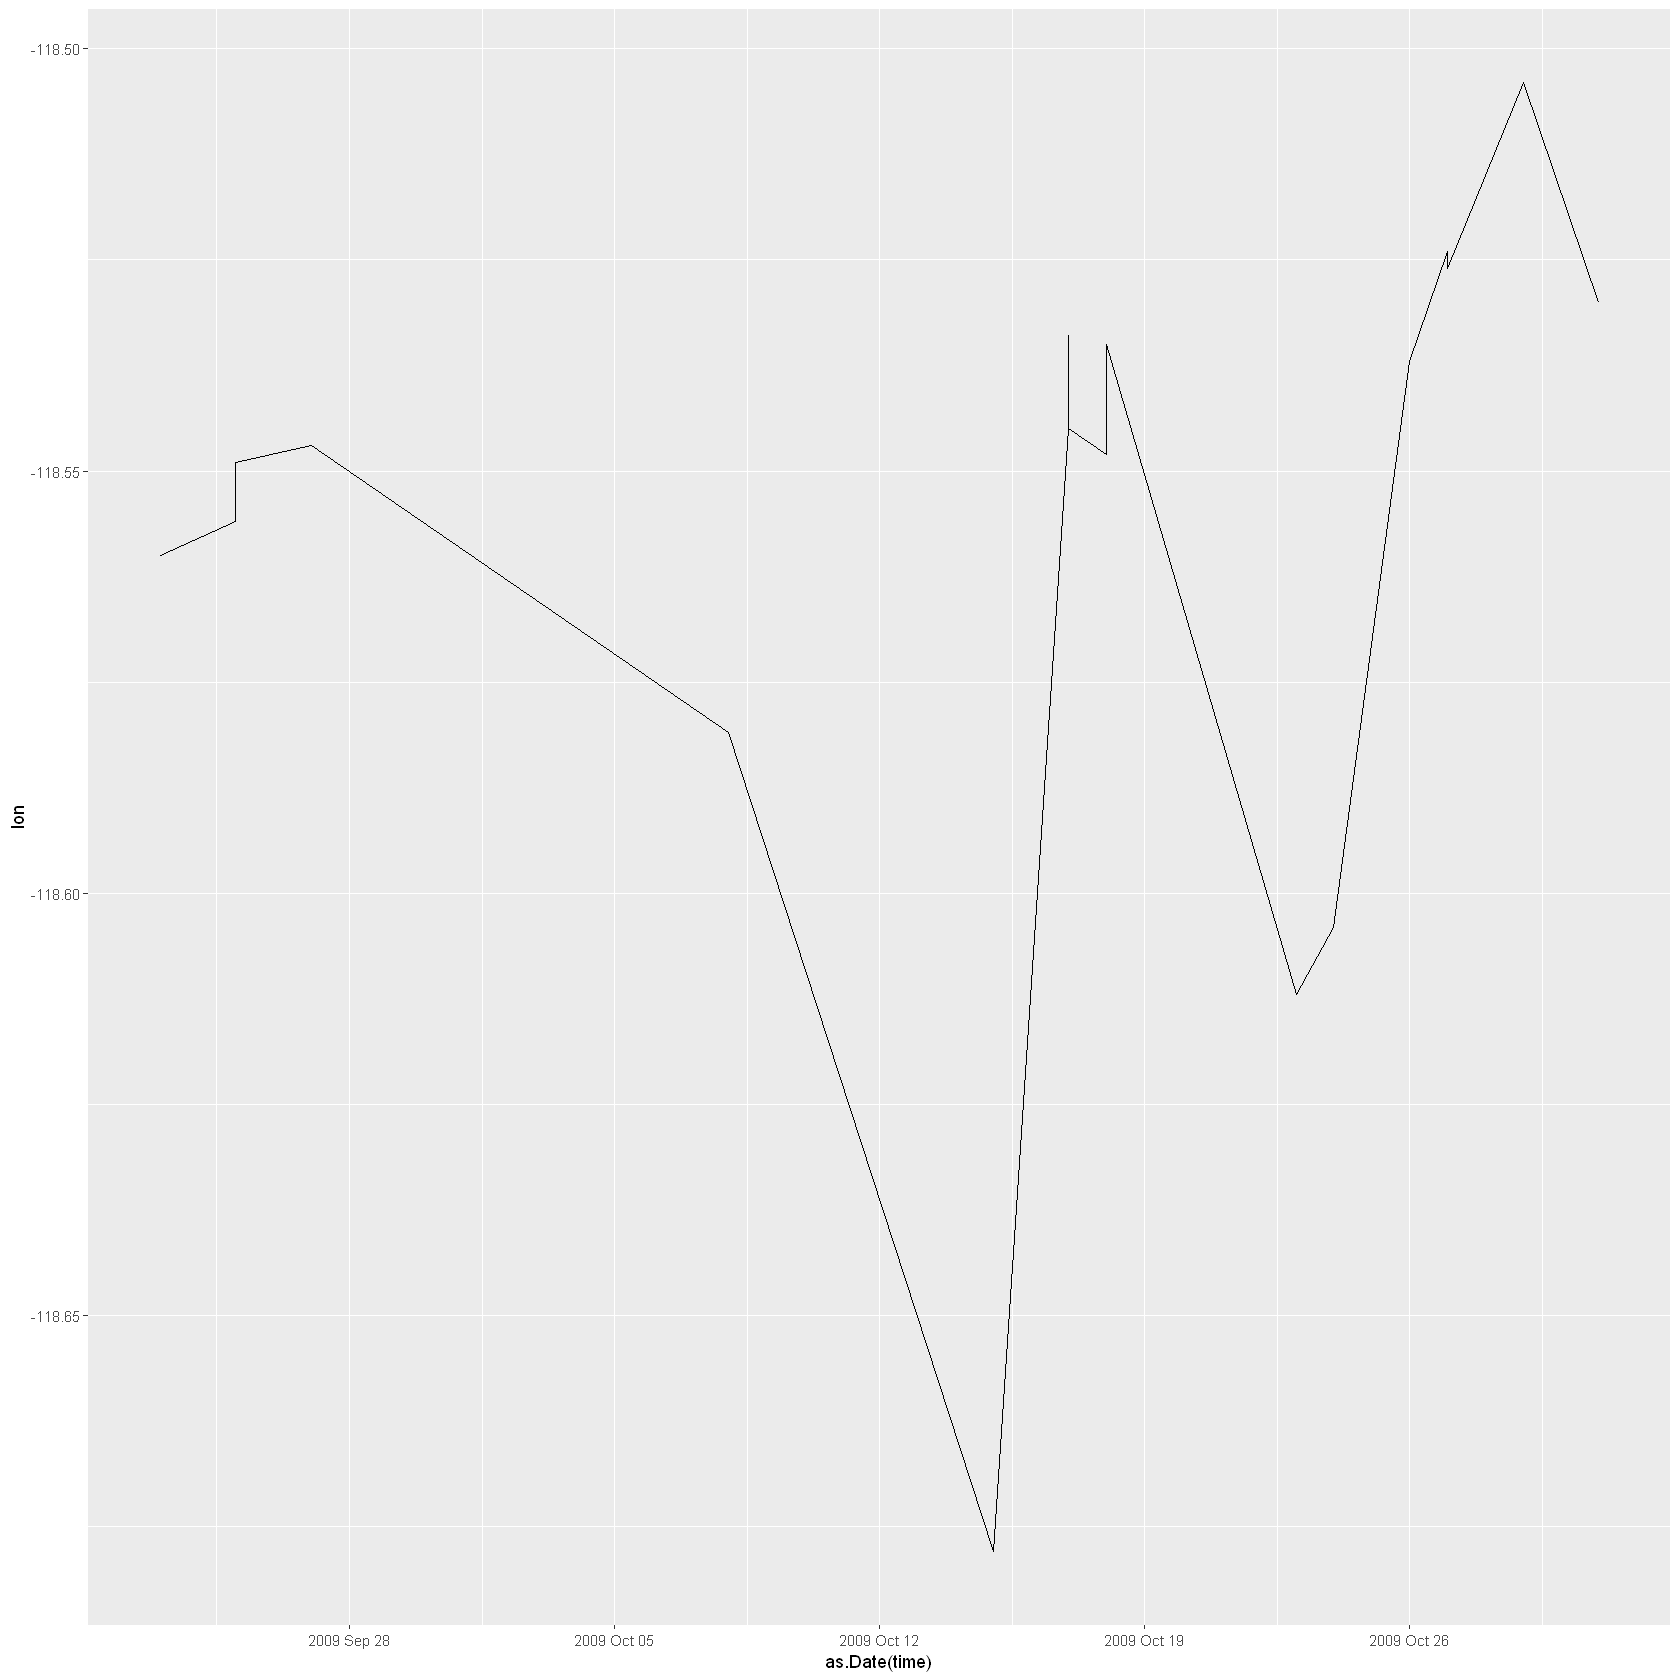

In [10]:
#library(ggplot2) - loaded with tidyverse

options(repr.plot.width = 14, repr.plot.height = 14)

ggplot(atn_tbl, aes(x=as.Date(time), y=lon)) + 
    geom_line() + 
    scale_x_date(date_labels = "%Y %b %d")

## Making a map

Next, let's make a map of the locations of this animal with the colors dependent on time.

Use the global attribute `title` as the title of the plot.

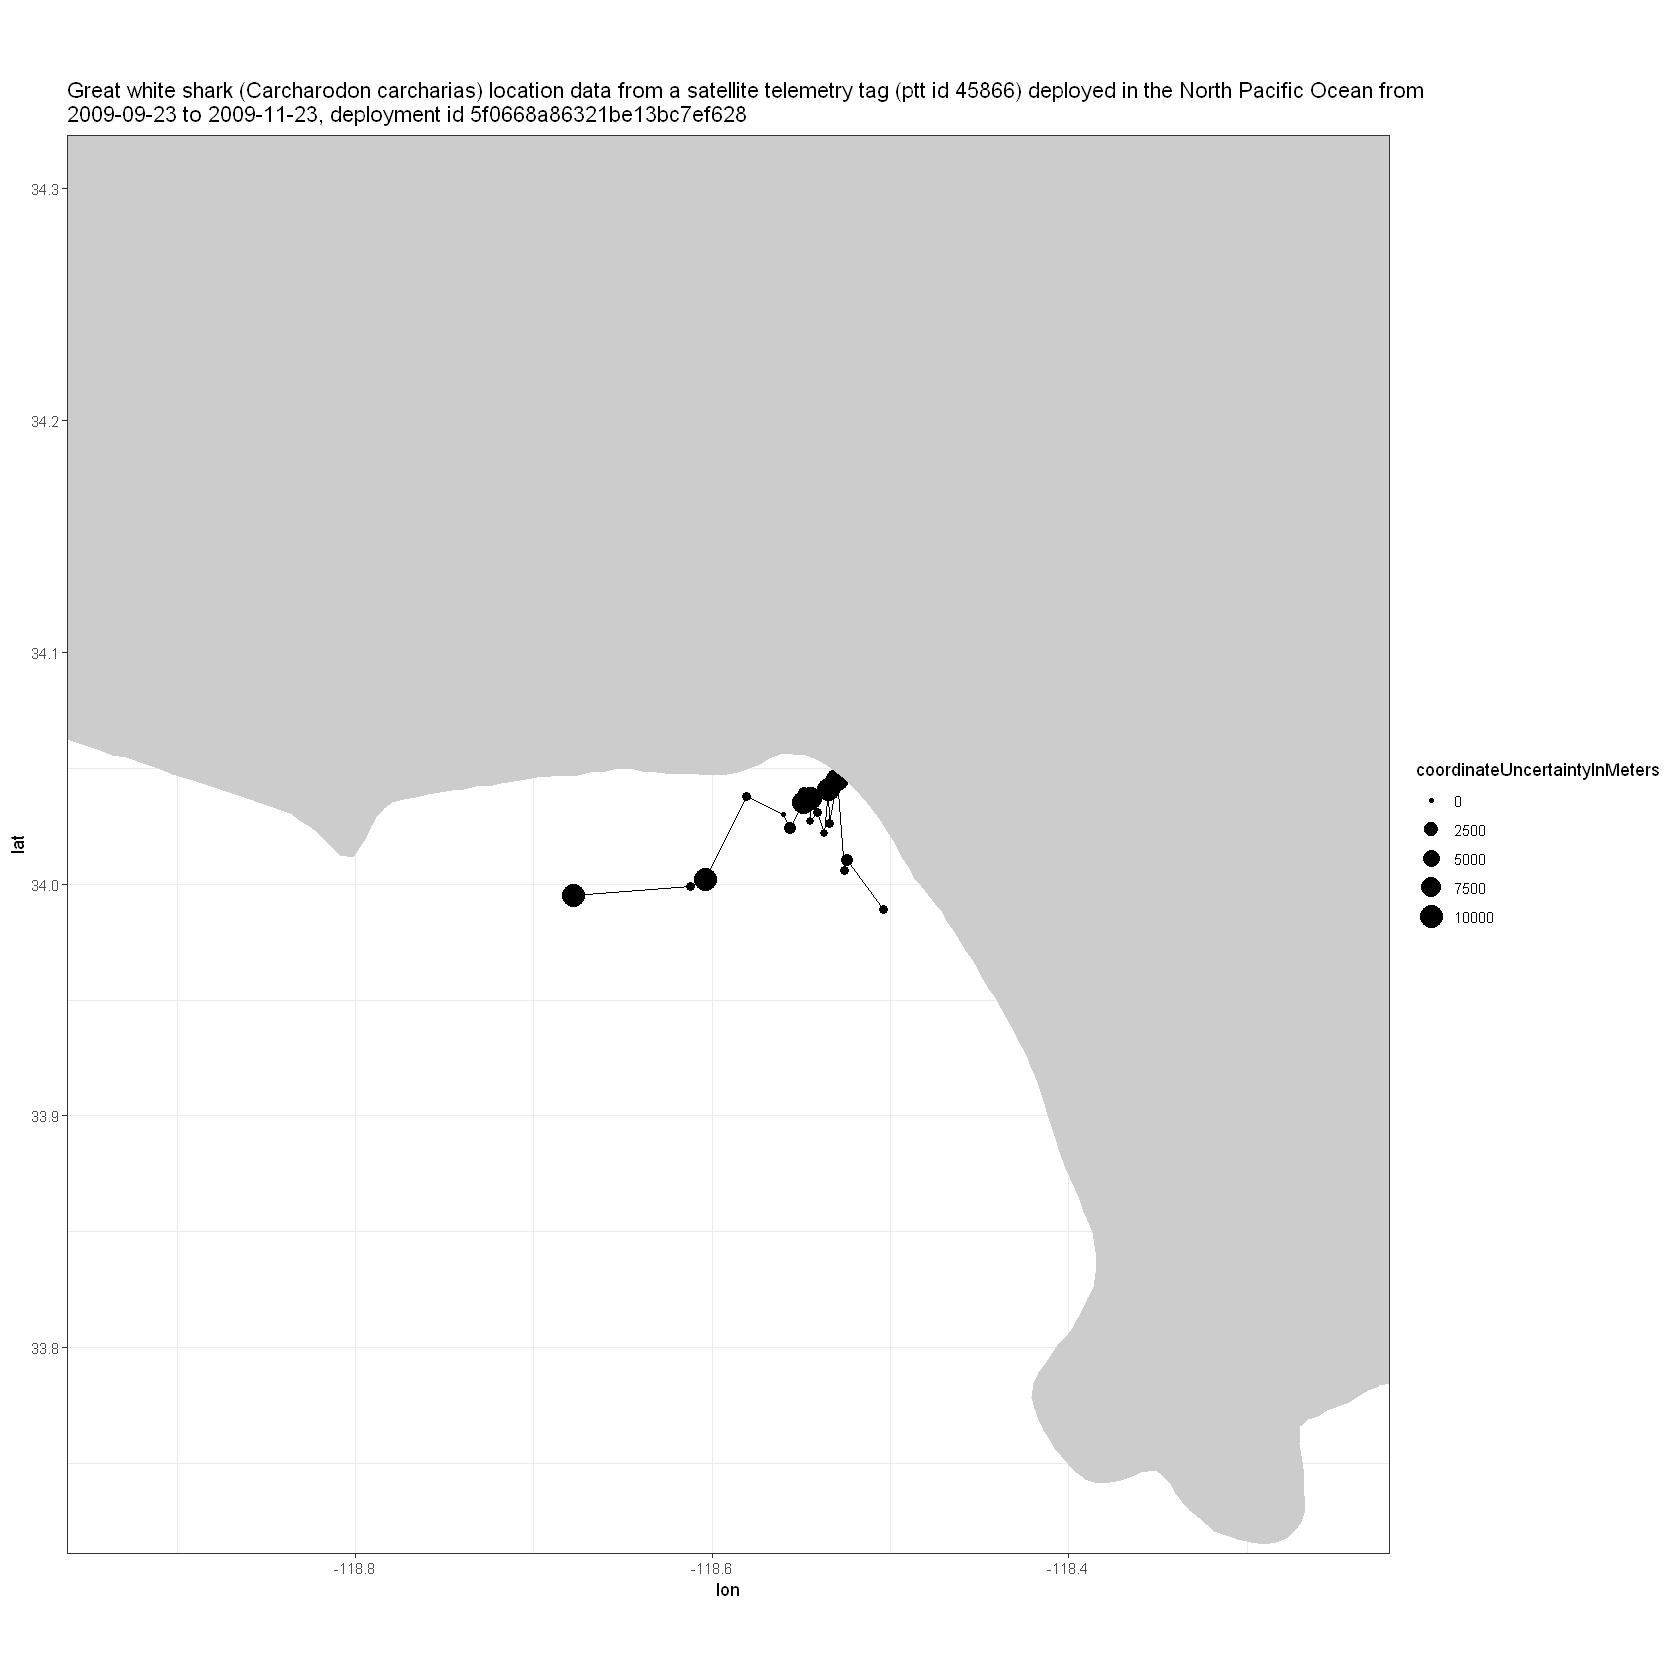

In [11]:
# collect title from global attributes
title <- metadata %>% dplyr::filter(variable == "NC_GLOBAL") %>% dplyr::filter(name == "title")


# Map limits.
ylim <- c( min(atn_tbl$lat)-0.25, max(atn_tbl$lat)+0.25 )
xlim <- c( min(atn_tbl$lon)-0.25, max(atn_tbl$lon)+0.25 )

# Get outline data for map.
w <- map_data( 'worldHires', ylim = ylim, xlim = xlim )

z <- ggplot(atn_tbl, aes( x = lon, y = lat )) +
     geom_point( aes(size = coordinateUncertaintyInMeters)) +
     geom_line() +
     scale_shape_manual( values = c(19, 1) )

z + geom_polygon(data = w, aes(x = long, y = lat, group = group), fill = 'grey80') + 
    theme_bw() +
    coord_fixed(1.3, xlim = xlim, ylim = ylim) + 
    #ggtitle( paste( strwrap(title$value, width = 150), collapse = "\n") ) - labs is a more mature and flexible function
    labs(title = paste( strwrap(title$value, width = 150), collapse = "\n"))

We need to prepare the data to send to the server. As mentioned above the request will take a table with a header `"time,latitude,longitude"`, then its values. Note that we rename the columns, then pick the subset to store as one long string to create the request.

In [12]:
time_lat_lon <- atn_tbl %>%
    rename(  # rename columns to ERDDAP terms
        latitude = lat,
        longitude = lon)

time_lat_lon <- format_csv(time_lat_lon[c('time','latitude','longitude')])

The cell below builds the request and download get it back as a data.frame.

In [13]:
response = "csv"
dataset_id = "jplMURSST41"
variable = "analysed_sst"
algorithm = "Nearest"
nearby = 216

url = paste0(
    "http://coastwatch.pfeg.noaa.gov/erddap/",
    "convert/interpolate.",response,
    "?TimeLatLonTable=",URLencode(time_lat_lon, reserved=TRUE),
    "&requestCSV=",dataset_id,
    "/",variable,
    "/",algorithm,
    "/",nearby
)

df <- read.csv(url)

Now let's plot what the interpolated sea surface temperatures were for that animal at that location and time.

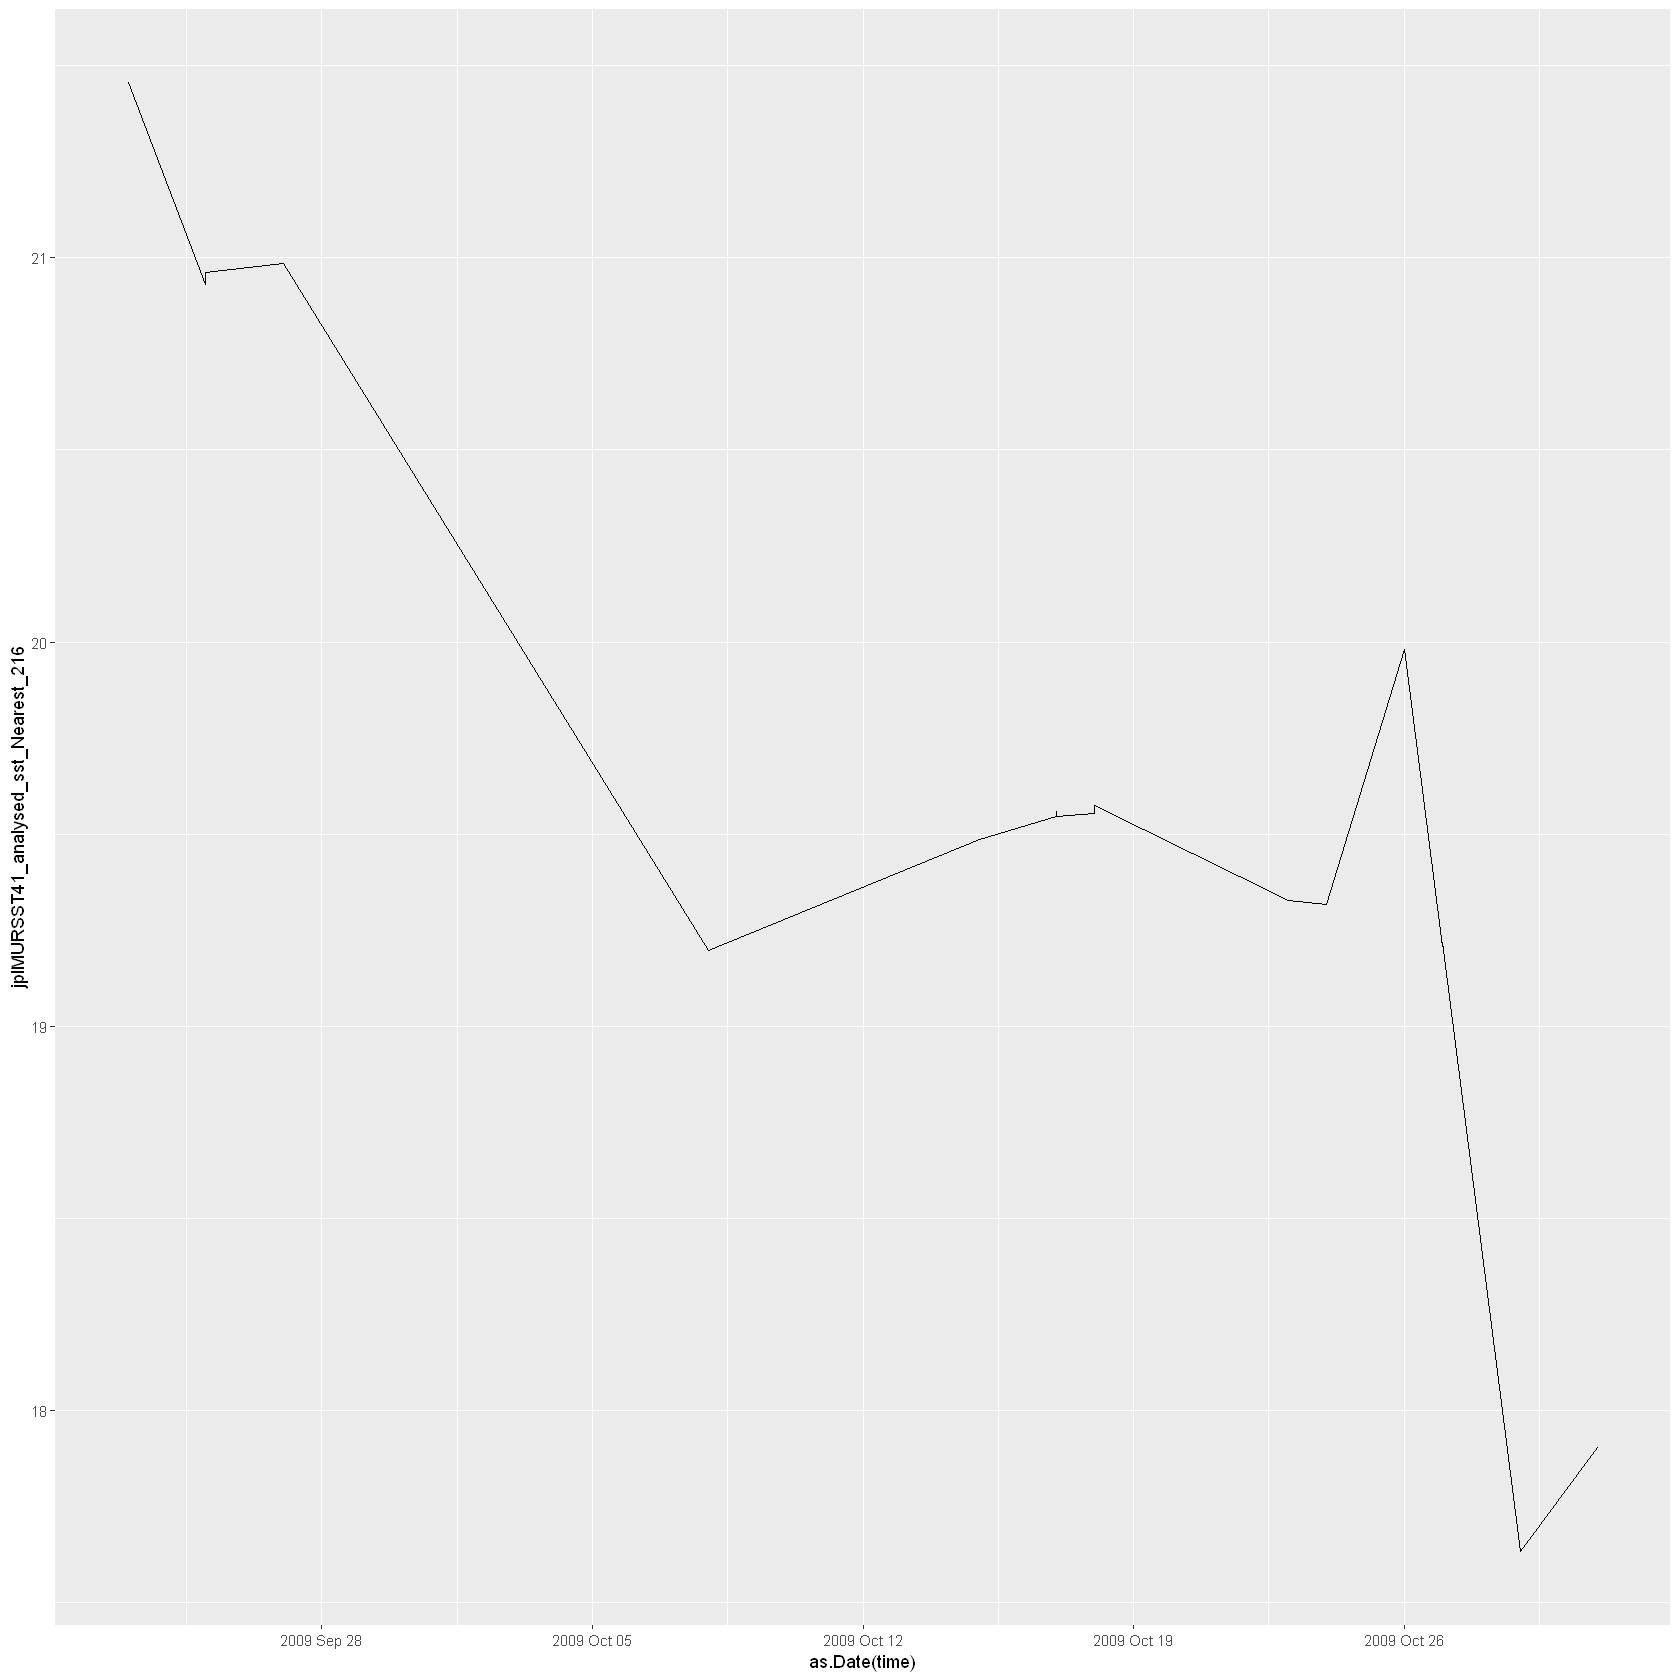

In [14]:
options(repr.plot.width = 14, repr.plot.height = 14)

ggplot(df, aes(x=as.Date(time), y=jplMURSST41_analysed_sst_Nearest_216)) + 
    geom_line() + 
    scale_x_date(date_labels = "%Y %b %d")

In [15]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] mapdata_2.3.1    maps_3.4.1       lubridate_1.9.2  forcats_1.0.0   
 [5] stringr_1.5.0    dplyr_1.1.1      purrr_1.0.1      readr_2.1.4     
 [9] tidyr_1.3.0      tibble_3.2.1     ggplot2_3.4.2    tidyverse_1.3.2 
[13] ncdf4_1.21       obistools_0.0.10 tidync_0.3.0    

loaded via a namespace (and not attached):
 [1] httr_1.4.6          bit64_4.0.5         vroom_1.6.1        
 [4] jsonlite_1.8.4      modelr_0.1.11       sp_2.0-0           
 [7] googlesheets4_1.1.0 cellranger_1.1.0    pillar_1.9.0    